<a href="https://colab.research.google.com/github/AndresRestrepoRodriguez/computer_vision/blob/main/Object_Localization_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
train = torchvision.datasets.VOCDetection('./data', download=True)
len(train)

  0%|          | 0/1999639040 [00:00<?, ?it/s]

Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


5717

In [3]:
classes = ["background",
            "aeroplane",
            "bicycle",
            "bird",
            "boat",
            "bottle",
            "bus",
            "car",
            "cat",
            "chair",
            "cow",
            "diningtable",
            "dog",
            "horse",
            "motorbike",
            "person",
            "pottedplant",
            "sheep",
            "sofa",
            "train",
            "tvmonitor"]

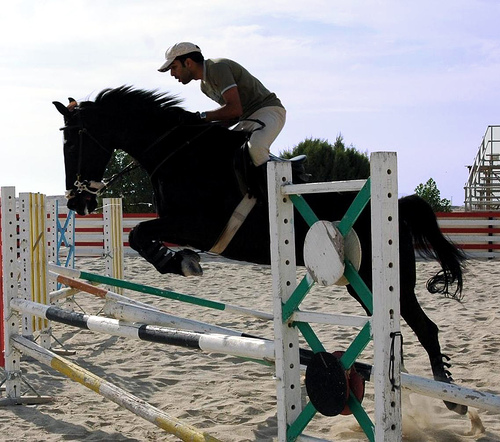

In [4]:
img, label = train[0]
img

In [5]:
label

{'annotation': {'filename': '2008_000008.jpg',
  'folder': 'VOC2012',
  'object': [{'bndbox': {'xmax': '471',
     'xmin': '53',
     'ymax': '420',
     'ymin': '87'},
    'difficult': '0',
    'name': 'horse',
    'occluded': '1',
    'pose': 'Left',
    'truncated': '0'},
   {'bndbox': {'xmax': '289', 'xmin': '158', 'ymax': '167', 'ymin': '44'},
    'difficult': '0',
    'name': 'person',
    'occluded': '0',
    'pose': 'Unspecified',
    'truncated': '1'}],
  'segmented': '0',
  'size': {'depth': '3', 'height': '442', 'width': '500'},
  'source': {'annotation': 'PASCAL VOC2008',
   'database': 'The VOC2008 Database',
   'image': 'flickr'}}}

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects
import random

def get_sample(ix):
  img, label = train[ix]
  img_np = np.array(img)
  anns = label['annotation']['object']
  if type(anns) is not list:
    anns = [anns]
  labels = np.array([classes.index(ann['name']) for ann in anns])
  bbs = [ann['bndbox'] for ann in anns]
  bbs = np.array([[int(bb['xmin']), int(bb['ymin']),int(bb['xmax'])-int(bb['xmin']),int(bb['ymax'])-int(bb['ymin'])] for bb in bbs])
  anns = (labels, bbs)
  return img_np, anns

def plot_anns(img, anns, ax=None, bg=-1):
  # anns is a tuple with (labels, bbs)
  # bbs is an array of bounding boxes in format [x_min, y_min, width, height] 
  # labels is an array containing the label 
  if not ax:
    fig, ax = plt.subplots(figsize=(10, 6))
  ax.imshow(img)
  labels, bbs = anns
  for lab, bb in zip(labels, bbs):
    if bg == -1 or lab != bg:
      x, y, w, h = bb
      rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
      text = ax.text(x, y - 10, classes[lab], {'color': 'red'})
      text.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
      ax.add_patch(rect)

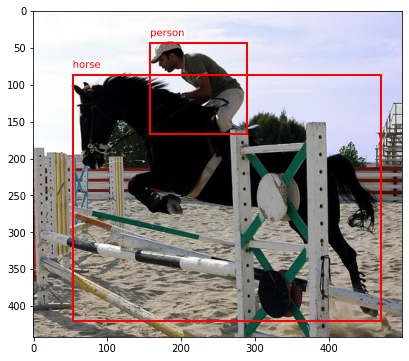

In [7]:
img_np, anns = get_sample(0)
plot_anns(img_np, anns)
plt.show()

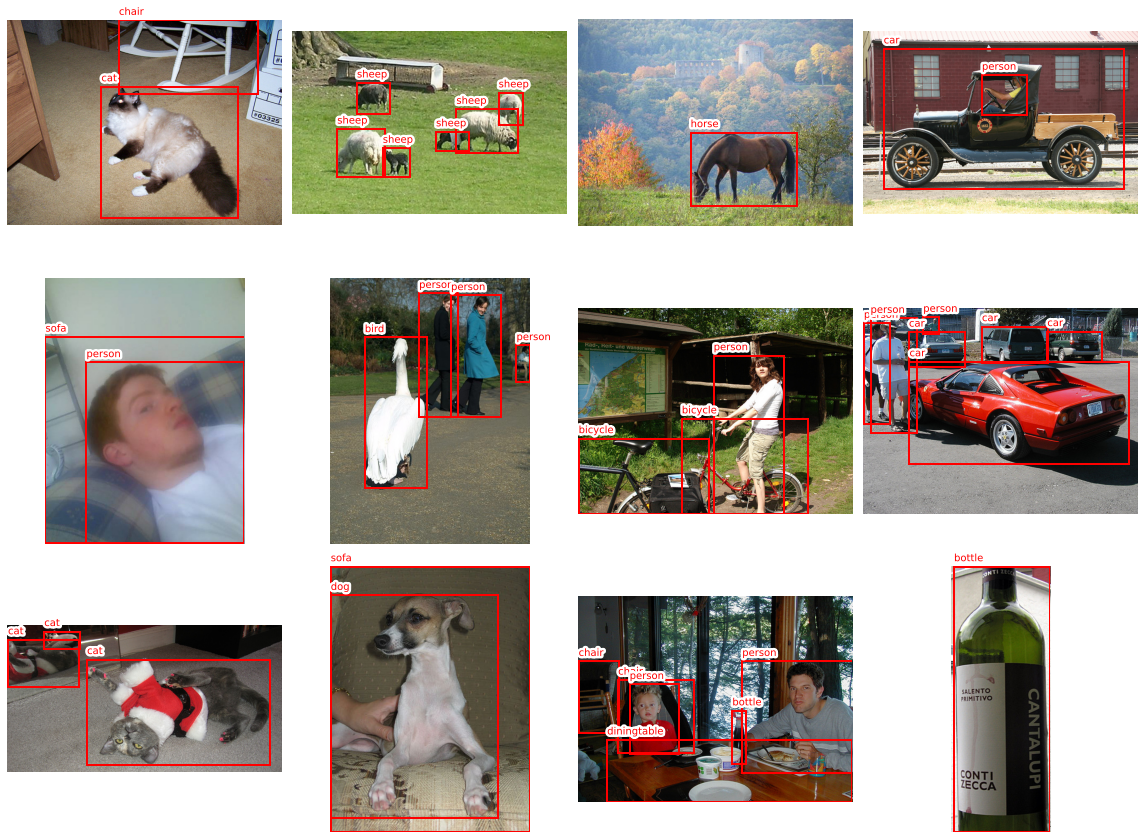

In [8]:
r, c = 3, 4
fig = plt.figure(figsize=(4*c, 4*r))
for _r in range(r):
    for _c in range(c):
        ax = plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(train)-1)
        img_np, anns = get_sample(ix)
        plot_anns(img_np, anns, ax)
        plt.axis("off")
plt.tight_layout()
plt.show()

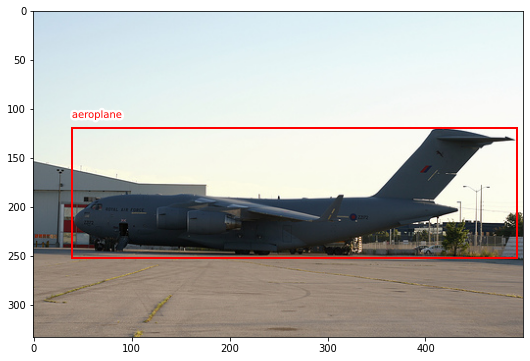

In [9]:
img_np, anns = get_sample(4445)
plot_anns(img_np, anns)
plt.show()

In [10]:
from torch.nn.modules.pooling import MaxPool2d
from torch.nn.modules.activation import ReLU


def block(channel_input, channel_output, kernel_size=3, padding=1, stride=1, pool_kernel=2, pool_stride=2):
  return torch.nn.Sequential(
      torch.nn.Conv2d(channel_input, channel_output, kernel_size,
                      padding=padding, stride=stride),
      torch.nn.ReLU(),
      torch.nn.MaxPool2d(pool_kernel, stride=pool_stride)
  )


def block2(channel_input, channel_output):
  return torch.nn.Sequential(
      torch.nn.Linear(channel_input, channel_output),
      torch.nn.ReLU()
  )

In [11]:
class Model(torch.nn.Module):
  def __init__(self, n_channels=3, n_outputs=4):
    super().__init__()
    self.conv1 = block(n_channels, channel_output=8)
    self.conv2 = block(channel_input=8, channel_output=16)
    self.conv3 = block(channel_input=16, channel_output=32)
    self.conv4 = block(channel_input=32, channel_output=64)
    self.fc1 = block2(channel_input=64*6*6, channel_output=100)
    self.fc2 = block2(channel_input=100, channel_output=n_outputs)
    
  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = x.view(x.shape[0], -1)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

In [12]:
model = Model()

In [13]:
import albumentations as A

def get_aug(aug, min_area=0, min_visibility=0):
  return A.Compose(aug, bbox_params={'format': 'coco', 'min_area': min_area, 'min_visibility': min_visibility, 'label_fields': ['labels']})

trans = get_aug([A.Resize(100, 100)])

labels, bbs = anns
augmented = trans(**{'image': img_np, 'bboxes': bbs, 'labels': labels})
img, bbs, labels = augmented['image'], augmented['bboxes'], augmented['labels']

img.shape, bbs

((100, 100, 3), [[7.8, 35.73573573573574, 90.8, 39.93993993993994]])

In [14]:
def norm(bb, shape):
  # normalize bb
  # shape = (heigh, width)
  # bb = [x_min, y_min, width, height]
  h, w = shape
  return np.array([bb[0]/w, bb[1]/h, bb[2]/w, bb[3]/h])

def unnorm(bb, shape):
  # normalize bb
  # shape = (heigh, width)
  # bb = [x_min, y_min, width, height]
  h, w = shape
  return np.array([bb[0]*w, bb[1]*h, bb[2]*w, bb[3]*h])

In [17]:
bb = bbs[0]
bb

[7.8, 35.73573573573574, 90.8, 39.93993993993994]

In [19]:
bb_norm = norm(bb, img.shape[:2])
bb_norm

array([0.078     , 0.35735736, 0.908     , 0.3993994 ])

In [20]:
bb_unnorm = unnorm(bb_norm, img.shape[:2])
bb_unnorm

array([ 7.8       , 35.73573574, 90.8       , 39.93993994])

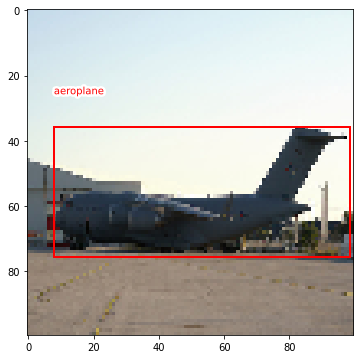

In [15]:
plot_anns(img, (labels, bbs))
plt.show()

In [22]:
def fit(model, X, y, epochs=1, lr=1e-3):
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  criterion = torch.nn.L1Loss()
  for epoch in range(1, epochs+1):
    model.train()
    train_loss = []
    X, y = X.to(device), y.to(device)
    optimizer.zero_grad()
    y_hat = model(X)
    loss = criterion(y_hat, y)
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
    print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f}")

In [23]:
model = Model()
img_tensor = torch.FloatTensor(img / 255.).permute(2,0,1).unsqueeze(0)
bb_tensor = torch.FloatTensor(bb_norm).unsqueeze(0)
fit(model, img_tensor, bb_tensor, epochs=30)

Epoch 1/30 loss 0.40941
Epoch 2/30 loss 0.36457
Epoch 3/30 loss 0.29970
Epoch 4/30 loss 0.21205
Epoch 5/30 loss 0.18310
Epoch 6/30 loss 0.15390
Epoch 7/30 loss 0.10441
Epoch 8/30 loss 0.07222
Epoch 9/30 loss 0.06011
Epoch 10/30 loss 0.03110
Epoch 11/30 loss 0.04744
Epoch 12/30 loss 0.03465
Epoch 13/30 loss 0.05222
Epoch 14/30 loss 0.04259
Epoch 15/30 loss 0.04875
Epoch 16/30 loss 0.05617
Epoch 17/30 loss 0.03771
Epoch 18/30 loss 0.01543
Epoch 19/30 loss 0.01789
Epoch 20/30 loss 0.01955
Epoch 21/30 loss 0.02233
Epoch 22/30 loss 0.02043
Epoch 23/30 loss 0.01888
Epoch 24/30 loss 0.01740
Epoch 25/30 loss 0.00988
Epoch 26/30 loss 0.00960
Epoch 27/30 loss 0.01380
Epoch 28/30 loss 0.01766
Epoch 29/30 loss 0.01608
Epoch 30/30 loss 0.00921


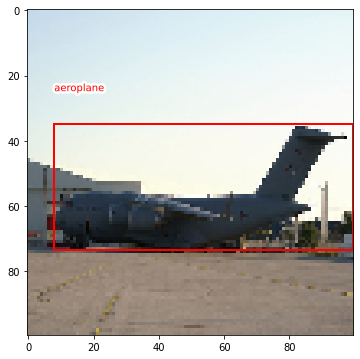

In [24]:
model.eval()
pred_bb_norm = model(img_tensor.to(device))[0].cpu().detach().numpy()
pred_bb = unnorm(pred_bb_norm, img.shape[:2])
plot_anns(img, (anns[0], [pred_bb]))
plt.show()